In [ ]:
import os
import pprint
from time import time
import threading
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, \
    QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.cross_validation import cross_val_score

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.style.use('ggplot')
# %matplotlib inline


from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

class Data:
    def __init__(self):
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.labels = None

    def load_data(self, train_rows=None, test_rows=None, shfl=False, scl=True):
        data_folder = os.path.join("../", "data")
        X_train_file_path = os.path.join(data_folder, "Train/X_train.txt")
        y_train_file_path = os.path.join(data_folder, "Train/y_train.txt")
        X_test_file_path = os.path.join(data_folder, "Test/X_test.txt")
        y_test_file_path = os.path.join(data_folder, "Test/y_test.txt")
        labels_file_path = os.path.join(data_folder, "activity_labels.txt")
        self.X_train = np.loadtxt(X_train_file_path, delimiter=' ')[
                       0:train_rows, :]
        self.y_train = np.loadtxt(y_train_file_path, delimiter=' ')[
                       0:train_rows, ]
        self.X_test = np.loadtxt(X_test_file_path, delimiter=' ')[0:test_rows,
                      :]
        self.y_test = np.loadtxt(y_test_file_path, delimiter=' ')[0:test_rows, ]
        lb = np.genfromtxt(labels_file_path, delimiter=' ', dtype=None)
        self.labels = np.asarray(map(lambda x: x[1], lb))
        if scl:
            StandardScaler().fit_transform(self.X_train)
        if shfl:
            self.X_train, self.y_train = shuffle(self.X_train, self.y_train)


class Classifiers:
    def __init__(self, data):
        self.X_train = data.X_train
        self.y_train = data.y_train
        self.X_test = data.X_test
        self.y_test = data.y_test
        self.y_predict = {}  # {k - name_of_classifier, v - [predictions]}
        self.cls = {}  # {k - name_of_classifier, v - sklearn_classifier_object}
        self.scores = {}  # {k - name_of_classifier, { k - score_metric,
        self.time = {}
        # v - score}}

    def add_classifier(self, classifier_name, classifier):
        self.cls[classifier_name] = classifier

    def __fit(self, cls, cls_name, X, y):
        t0 = time()
        cls.fit(X, y)
        print("%s done in %0.3fs" % (cls_name, time() - t0))

    def fit(self):
        threads = []
        for classifier_name, classifier in self.cls.items():
            th = threading.Thread(target=self.__fit, args=(
                classifier, classifier_name, self.X_train, self.y_train,))
            threads.append(th)
            th.start()

        for th in threads:
            th.join()
            
    def predict(self):
        for classifier_name, classifier in self.cls.items():
            start_time = time()
            self.y_predict[classifier_name] = classifier.predict(self.X_test)
            self.time[classifier_name] = time() - start_time

    def get_scores(self):
        for classifier_name, classifier in self.cls.items():
            self.__get_score(classifier_name, classifier)

    def __get_score(self, classifier_name, classifier):
        self.scores[classifier_name] = {
            "accuracy": accuracy_score(self.y_test,
                                       self.y_predict[classifier_name]),
            "precision": precision_score(self.y_test,
                                         self.y_predict[classifier_name],
                                         average='weighted'),
            "recall": recall_score(self.y_test,
                                   self.y_predict[classifier_name],
                                   average='weighted')
        }

    def print_scores_sys(self):
        pprint.pprint(self.scores)

    def print_scores(self):
        df = pd.DataFrame(self.scores)
        df.transpose()
        df.sort()
        display(df)

    def show_plt(self):
        cls_names = []
        accuracy = []
        precision = []
        recall = []
        for name, score_values in self.scores.items():
            cls_names.append(name)
            # print(score_values)
            for score_type, v in score_values.items():
                if score_type == 'accuracy':
                    accuracy.append(v)
                elif score_type == 'precision':
                    precision.append(v)
                elif score_type == 'recall':
                    recall.append(v)
        accuracy, cls_names = (list(t) for t in
                               zip(*sorted(zip(accuracy, cls_names))))
        plt.figure(figsize=(7, 7))
        plt.barh(np.arange(len(cls_names)), accuracy, align='center', alpha=0.4)
        plt.yticks(np.arange(len(cls_names)), cls_names)
        plt.ylabel("Classifiers")
        plt.xlabel("Accuracy")
        plt.subplots_adjust(left=.3)
        plt.title("Accuracy vs. Classifiers")

In [101]:
# Computing calssifier accuracy values for different PCA values
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, \
    QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
pca_values = [2, 5, 10, 25, 30, 40, 50, 100, 150, 200, 250, 300, 561]
# pca_values = [561]

scores = {}

for v in pca_values:
        data = Data()
        # data.load_data(3000)
        data.load_data(shfl=True)
        print("Running PCA with %s components" % v)
        pca = PCA(n_components=v)
        data.X_train = pca.fit_transform(data.X_train)
        data.X_test = pca.transform(data.X_test)
        cls = Classifiers(data)
        dtc = DecisionTreeClassifier()
        gnb = GaussianNB()
        lda = LinearDiscriminantAnalysis()
        qda = QuadraticDiscriminantAnalysis()
        linear_svc = svm.SVC(kernel='linear', class_weight='balanced')
        poly_svc = svm.SVC(kernel='poly', class_weight='balanced')
        rbf_svc = svm.SVC(kernel='rbf', class_weight='balanced')
        knn = KNeighborsClassifier(12)        
        rfc = RandomForestClassifier(n_estimators=10, max_features=0.8)
        cls.add_classifier("knn", knn)
        cls.add_classifier("decision-trees", dtc)
        cls.add_classifier("gaussian-naive-bayes", gnb)
        cls.add_classifier("linear-discriminant-analysis", lda)
        cls.add_classifier("quadratic-discriminant-analysis", qda)
        cls.add_classifier("linear-support-vector-machine", linear_svc)
        cls.add_classifier("poly-support-vector-machine", poly_svc)
        cls.add_classifier("rbf-support-vector-machine", rbf_svc)
        cls.add_classifier("random-forest", rfc)

        cls.fit()
        cls.predict()
        cls.get_scores()
        cls.print_scores()
        for k, v in cls.scores.items():
            try:
                scores[k] += [v["accuracy"]]
            except KeyError:
                scores[k] = [v["accuracy"]]

Running PCA with 2 components
knn done in 0.008s
quadratic-discriminant-analysis done in 0.024s
gaussian-naive-bayes done in 0.025s
linear-discriminant-analysis done in 0.027s
decision-trees done in 0.049s
random-forest done in 0.140s
linear-support-vector-machine done in 0.845s
rbf-support-vector-machine done in 0.975s
poly-support-vector-machine done in 40.559s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.545857,0.552182,0.612903,0.532258,0.588235,0.622391,0.581278,0.576218,0.634725
precision,0.547213,0.553499,0.622061,0.511077,0.615839,0.638915,0.576869,0.582969,0.654015
recall,0.545857,0.552182,0.612903,0.532258,0.588235,0.622391,0.581278,0.576218,0.634725


Running PCA with 5 components
knn done in 0.008s
quadratic-discriminant-analysis done in 0.029s
gaussian-naive-bayes done in 0.029s
linear-discriminant-analysis done in 0.034s
decision-trees done in 0.070s
random-forest done in 0.321s
linear-support-vector-machine done in 0.453s
rbf-support-vector-machine done in 0.633s
poly-support-vector-machine done in 1.996s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.730234,0.769133,0.791271,0.779570,0.776091,0.779570,0.767236,0.773245,0.791588
precision,0.733261,0.776915,0.796596,0.787914,0.792116,0.791198,0.786374,0.775471,0.804042
recall,0.730234,0.769133,0.791271,0.779570,0.776091,0.779570,0.767236,0.773245,0.791588


Running PCA with 10 components
knn done in 0.017s
quadratic-discriminant-analysis done in 0.033s
gaussian-naive-bayes done in 0.088s
linear-discriminant-analysis done in 0.195s
decision-trees done in 0.252s
linear-support-vector-machine done in 0.556s
poly-support-vector-machine done in 0.680s
random-forest done in 0.735s
rbf-support-vector-machine done in 0.775s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.763757,0.813093,0.823846,0.835863,0.847565,0.856104,0.829222,0.827324,0.855155
precision,0.768090,0.818691,0.827453,0.840158,0.852150,0.859710,0.838513,0.827121,0.857805
recall,0.763757,0.813093,0.823846,0.835863,0.847565,0.856104,0.829222,0.827324,0.855155


Running PCA with 25 components
knn done in 0.018s
quadratic-discriminant-analysis done in 0.050s
gaussian-naive-bayes done in 0.052s
linear-discriminant-analysis done in 0.081s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


decision-trees done in 0.368s
linear-support-vector-machine done in 0.477s
poly-support-vector-machine done in 0.565s
rbf-support-vector-machine done in 0.789s
random-forest done in 1.339s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.785895,0.850727,0.859266,0.860848,0.886148,0.888678,0.882353,0.85389,0.899114
precision,0.790432,0.855135,0.864326,0.867189,0.886843,0.892200,0.886499,0.85553,0.900763
recall,0.785895,0.850727,0.859266,0.860848,0.886148,0.888678,0.882353,0.85389,0.899114


Running PCA with 30 components
knn done in 0.029s
quadratic-discriminant-analysis done in 0.061s
gaussian-naive-bayes done in 0.066s
linear-discriminant-analysis done in 0.092s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


decision-trees done in 0.388s
linear-support-vector-machine done in 0.493s
poly-support-vector-machine done in 0.629s
rbf-support-vector-machine done in 0.784s
random-forest done in 1.618s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.783997,0.856736,0.870019,0.865908,0.889311,0.891841,0.886464,0.854522,0.903226
precision,0.787397,0.860743,0.874413,0.872161,0.889897,0.896103,0.893860,0.855021,0.905765
recall,0.783997,0.856736,0.870019,0.865908,0.889311,0.891841,0.886464,0.854522,0.903226


Running PCA with 40 components
knn done in 0.044s
quadratic-discriminant-analysis done in 0.135s
gaussian-naive-bayes done in 0.135s
linear-discriminant-analysis done in 0.198s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


decision-trees done in 0.657s
linear-support-vector-machine done in 0.778s
poly-support-vector-machine done in 1.163s
rbf-support-vector-machine done in 1.219s
random-forest done in 2.469s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.773561,0.861164,0.870651,0.886464,0.909867,0.896584,0.898166,0.849779,0.909235
precision,0.775714,0.866866,0.875113,0.891674,0.909864,0.902986,0.902451,0.848823,0.911876
recall,0.773561,0.861164,0.870651,0.886464,0.909867,0.896584,0.898166,0.849779,0.909235


Running PCA with 50 components
knn done in 0.030s
quadratic-discriminant-analysis done in 0.091s
gaussian-naive-bayes done in 0.094s
linear-discriminant-analysis done in 0.145s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


decision-trees done in 0.778s
linear-support-vector-machine done in 0.797s
rbf-support-vector-machine done in 1.301s
poly-support-vector-machine done in 1.467s
random-forest done in 2.807s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.775775,0.858634,0.877609,0.890576,0.912713,0.893738,0.902910,0.856420,0.913662
precision,0.778443,0.863284,0.881373,0.894424,0.913035,0.900980,0.901966,0.856976,0.915140
recall,0.775775,0.858634,0.877609,0.890576,0.912713,0.893738,0.902910,0.856420,0.913662


Running PCA with 100 components
knn done in 0.050s
gaussian-naive-bayes done in 0.294s
quadratic-discriminant-analysis done in 0.328s
linear-discriminant-analysis done in 0.456s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


linear-support-vector-machine done in 1.402s
decision-trees done in 1.566s
rbf-support-vector-machine done in 2.770s
poly-support-vector-machine done in 6.256s
random-forest done in 6.430s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.768501,0.857685,0.884883,0.922517,0.931056,0.858950,0.886781,0.862745,0.931373
precision,0.772834,0.863111,0.889165,0.923759,0.931354,0.883838,0.844657,0.861717,0.932493
recall,0.768501,0.857685,0.884883,0.922517,0.931056,0.858950,0.886781,0.862745,0.931373


Running PCA with 150 components
knn done in 0.080s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


quadratic-discriminant-analysis done in 0.429s
gaussian-naive-bayes done in 0.440s
linear-discriminant-analysis done in 0.634s
linear-support-vector-machine done in 2.069s
decision-trees done in 2.427s
rbf-support-vector-machine done in 3.850s
random-forest done in 8.943s
poly-support-vector-machine done in 12.662s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.785262,0.824162,0.884883,0.934851,0.942125,0.780202,0.889311,0.853890,0.931056
precision,0.789104,0.839578,0.889855,0.935064,0.942787,0.828420,0.850597,0.853271,0.931933
recall,0.785262,0.824162,0.884883,0.934851,0.942125,0.780202,0.889311,0.853890,0.931056


Running PCA with 200 components
knn done in 0.100s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


gaussian-naive-bayes done in 0.411s
quadratic-discriminant-analysis done in 0.414s
linear-discriminant-analysis done in 0.664s
linear-support-vector-machine done in 2.072s
decision-trees done in 3.016s
rbf-support-vector-machine done in 5.433s
random-forest done in 12.408s
poly-support-vector-machine done in 23.301s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.786528,0.802657,0.885199,0.944339,0.948134,0.718533,0.885199,0.857052,0.932638
precision,0.788229,0.827285,0.890345,0.945071,0.948832,0.794852,0.850758,0.855031,0.933484
recall,0.786528,0.802657,0.885199,0.944339,0.948134,0.718533,0.885199,0.857052,0.932638


Running PCA with 250 components
knn done in 0.146s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


quadratic-discriminant-analysis done in 0.495s
gaussian-naive-bayes done in 0.501s
linear-discriminant-analysis done in 0.812s
linear-support-vector-machine done in 2.560s
decision-trees done in 3.632s
rbf-support-vector-machine done in 6.680s
random-forest done in 14.869s
poly-support-vector-machine done in 35.941s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.772929,0.784314,0.885832,0.950348,0.952245,0.585389,0.870968,0.849462,0.932005
precision,0.776045,0.811096,0.891063,0.951032,0.952853,0.603572,0.839307,0.849643,0.932911
recall,0.772929,0.784314,0.885832,0.950348,0.952245,0.585389,0.870968,0.849462,0.932005


Running PCA with 300 components
knn done in 0.257s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


gaussian-naive-bayes done in 1.032s
quadratic-discriminant-analysis done in 1.037s
linear-discriminant-analysis done in 1.564s
linear-support-vector-machine done in 3.580s
decision-trees done in 4.925s
rbf-support-vector-machine done in 8.903s
random-forest done in 17.434s
poly-support-vector-machine done in 49.309s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.777672,0.764073,0.885199,0.951297,0.952562,0.542378,0.862429,0.862113,0.928526
precision,0.780827,0.796078,0.890473,0.952335,0.953127,0.582438,0.832253,0.861321,0.929698
recall,0.777672,0.764073,0.885199,0.951297,0.952562,0.542378,0.862429,0.862113,0.928526


Running PCA with 561 components


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


knn done in 0.443s
quadratic-discriminant-analysis done in 1.837s
gaussian-naive-bayes done in 1.835s
linear-discriminant-analysis done in 2.548s
linear-support-vector-machine done in 5.370s
decision-trees done in 7.475s
rbf-support-vector-machine done in 18.386s
random-forest done in 29.540s
poly-support-vector-machine done in 126.392s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.771980,0.701139,0.884883,0.951929,0.952562,0.182796,0.827641,0.849779,0.916192
precision,0.774069,0.739689,0.890326,0.953290,0.953158,0.252018,0.802449,0.848807,0.918147
recall,0.771980,0.701139,0.884883,0.951929,0.952562,0.182796,0.827641,0.849779,0.916192


In [102]:
cls.print_scores()

,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.771980,0.701139,0.884883,0.951929,0.952562,0.182796,0.827641,0.849779,0.916192
precision,0.774069,0.739689,0.890326,0.953290,0.953158,0.252018,0.802449,0.848807,0.918147
recall,0.771980,0.701139,0.884883,0.951929,0.952562,0.182796,0.827641,0.849779,0.916192


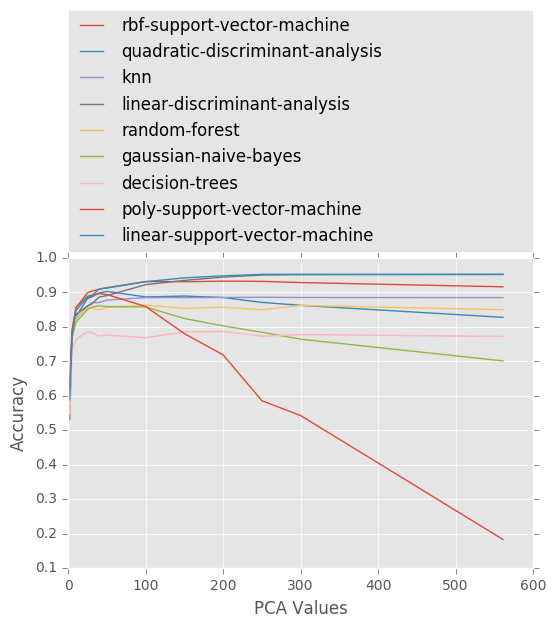

In [103]:
#Creating PCA values vs Accuracy Graph
for k, v in scores.items():
    plt.plot(pca_values, v, label=k)
plt.xlabel("PCA Values")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
plt.show()

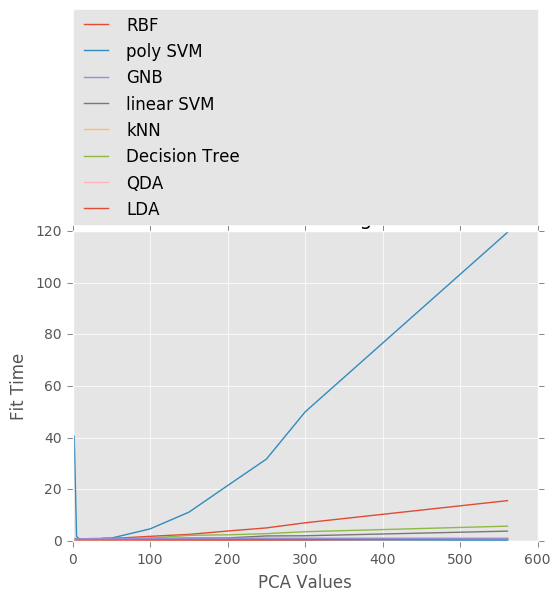

In [110]:
# Fitting time for each classifier graph
fit_times = {
    "RBF": [0.975, 0.482, 0.520, 0.616, 0.638, 0.799, 0.933, 1.787, 2.535, 3.845, 5.046, 7.022, 15.602],
"QDA": [0.024, 0.003, 0.004, 0.017, 0.019, 0.021, 0.030, 0.058, 0.093, 0.100, 0.152, 0.214, 0.863],
"kNN": [0.008, 0.005, 0.006, 0.010, 0.011, 0.012, 0.015, 0.029, 0.041, 0.057, 0.075, 0.097, 0.368],
"LDA": [0.027, 0.004, 0.005, 0.014, 0.015, 0.015, 0.024, 0.065, 0.078, 0.146, 0.216, 0.253, 0.680],
"GNB":[0.025, 0.002, 0.002, 0.004, 0.004, 0.005, 0.006, 0.014, 0.020, 0.037, 0.039, 0.050, 0.115],
"Decision Tree":[0.049, 0.047, 0.092, 0.246, 0.294, 0.409, 0.517, 1.091, 2.161, 2.374, 2.826, 3.580, 5.724],
"poly SVM":[40.559, 1.734, 0.405, 0.380, 0.453, 1.090, 1.102, 4.681, 11.141, 21.451, 31.694, 49.976, 119.453],
"linear SVM":[0.845, 0.296, 0.312, 0.316, 0.327, 0.629, 0.477, 0.696, 1.096, 1.167, 1.937, 2.006, 3.800]
}
for k, v in fit_times.items():
    plt.plot(pca_values, v, label=k)
plt.xlabel("PCA Values")
plt.ylabel("Fit Time")
plt.title("Classifier vs Fitting Time")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

for k, v in saved_scores.items():
#     print(k, v)
    plt.plot(pca_values, v, label=k)
plt.show()

In [146]:
# Plotting the prediction time graph
predict_time = {}

data = Data()
# data.load_data(3000)
data.load_data(shfl=True)
cls = Classifiers(data)
dtc = DecisionTreeClassifier()
gnb = GaussianNB()
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
linear_svc = svm.SVC(kernel='linear', class_weight='balanced')
poly_svc = svm.SVC(kernel='poly', class_weight='balanced')
rbf_svc = svm.SVC(kernel='rbf', class_weight='balanced')
knn = KNeighborsClassifier(12)
cls.add_classifier("knn", knn)
cls.add_classifier("decision-trees", dtc)
cls.add_classifier("gaussian-naive-bayes", gnb)
cls.add_classifier("linear-discriminant-analysis", lda)
cls.add_classifier("quadratic-discriminant-analysis", qda)
cls.add_classifier("linear-support-vector-machine", linear_svc)
cls.add_classifier("poly-support-vector-machine", poly_svc)
cls.add_classifier("rbf-support-vector-machine", rbf_svc)
cls.fit()
cls.predict()

//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


knn done in 0.318s
quadratic-discriminant-analysis done in 1.075s
gaussian-naive-bayes done in 1.096s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


linear-discriminant-analysis done in 1.706s
linear-support-vector-machine done in 4.304s
decision-trees done in 6.503s
rbf-support-vector-machine done in 15.940s
poly-support-vector-machine done in 24.249s


TypeError: 'module' object is not callable

In [147]:
for k, v in cls.time.items():
    print(k, v)
objects = cls.time.keys()
y_pos = np.arange(len(objects))
performance = cls.time.values()
plt.figure(figsize=(7, 7))
plt.barh(y_pos, performance, align='center', alpha=0.4)
plt.yticks(y_pos, objects)
plt.xlabel('Prediction Time')
plt.title('Prediction Time vs. Classifier')
plt.subplots_adjust(left=.3)
plt.show()

quadratic-discriminant-analysis 242
gaussian-naive-bayes 187
linear-discriminant-analysis 6
rbf-support-vector-machine 11907
decision-trees 4
poly-support-vector-machine 14658
linear-support-vector-machine 3286
knn 21040


In [112]:
# Comparison of classifiers with no data shuffling
def cls_compare_no_shuff():
    data = Data()
    data.load_data(shfl=False)
    cls = Classifiers(data)
    dtc = DecisionTreeClassifier()
    gnb = GaussianNB()
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    linear_svc = svm.SVC(kernel='linear', class_weight='balanced')
    poly_svc = svm.SVC(kernel='poly', class_weight='balanced')
    rbf_svc = svm.SVC(kernel='rbf', class_weight='balanced')
    # LinearSVC minimizes the squared hinge loss while SVC minimizes the
    # regular hinge loss.
    # LinearSVC uses the One-vs-All (also known as One-vs-Rest) multiclass
    # reduction while
    # SVC uses the One-vs-One multiclass reduction.
    rfc = RandomForestClassifier()
    knn = KNeighborsClassifier(12)
    cls.add_classifier("knn", knn)
    cls.add_classifier("decision-trees", dtc)
    cls.add_classifier("random-forest", rfc)
    cls.add_classifier("gaussian-naive-bayes", gnb)
    cls.add_classifier("linear-discriminant-analysis", lda)
    cls.add_classifier("quadratic-discriminant-analysis", qda)
    cls.add_classifier("linear-support-vector-machine", linear_svc)
    cls.add_classifier("poly-support-vector-machine", poly_svc)
    cls.add_classifier("rbf-support-vector-machine", rbf_svc)
    cls.fit()
    cls.predict()
    cls.get_scores()
    cls.print_scores()
    cls.show_plt()

In [113]:
# Comparison of classifiers with data shuffling
def cls_compare_shuff():
    data = Data()
    data.load_data(shfl=True)
    cls = Classifiers(data)
    dtc = DecisionTreeClassifier()
    gnb = GaussianNB()
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    linear_svc = svm.SVC(kernel='linear')
    poly_svc = svm.SVC(kernel='poly')
    rbf_svc = svm.SVC(kernel='rbf')
    rfc = RandomForestClassifier()
    knn = KNeighborsClassifier(12)
    cls.add_classifier("knn", knn)
    cls.add_classifier("decision-trees", dtc)
    cls.add_classifier("random-forest", rfc)
    cls.add_classifier("gaussian-naive-bayes", gnb)
    cls.add_classifier("linear-discriminant-analysis", lda)
    cls.add_classifier("quadratic-discriminant-analysis", qda)
    cls.add_classifier("linear-support-vector-machine", linear_svc)
    cls.add_classifier("poly-support-vector-machine", poly_svc)
    cls.add_classifier("rbf-support-vector-machine", rbf_svc)
    cls.fit()
    cls.predict()
    cls.get_scores()
    cls.print_scores()
    cls.show_plt()

In [114]:
# SVM with all features unweighted
def svm_all_unweighted():
    data = Data()
    data.load_data(shfl=True)
    cls = Classifiers(data)
    linear_svc = svm.SVC(kernel='linear')
    poly_svc = svm.SVC(kernel='poly')
    rbf_svc = svm.SVC(kernel='rbf')
    cls.add_classifier("linear-support-vector-machine", linear_svc)
    cls.add_classifier("poly-support-vector-machine", poly_svc)
    cls.add_classifier("rbf-support-vector-machine", rbf_svc)
    cls.fit()
    cls.predict()
    cls.get_scores()
    cls.print_scores()
    cls.show_plt()

In [115]:
# SVM with weighted features
def svm_all_weighted():
    data = Data()
    data.load_data(shfl=True)
    cls = Classifiers(data)
    linear_svc = svm.SVC(kernel='linear', C=1.00092594323,
                         class_weight='balanced')
    poly_svc = svm.SVC(kernel='poly', class_weight='balanced')
    rbf_svc = svm.SVC(kernel='rbf', class_weight='balanced')
    cls.add_classifier("linear-support-vector-machine", linear_svc)
    cls.add_classifier("poly-support-vector-machine", poly_svc)
    cls.add_classifier("rbf-support-vector-machine", rbf_svc)
    cls.fit()
    cls.predict()
    cls.get_scores()
    cls.print_scores()
    cls.show_plt()

In [116]:
# SVM Linear with grid search
def svm_linear_grid_search():
    data = Data()
    data.load_data()
    cls = Classifiers(data)
    # Default c = 1
    param_grid = {'C': [1, 1e3, 5e3, 1e4, 5e4, 1e5]}
    linear_svc = GridSearchCV(
        svm.SVC(kernel='linear'),
        param_grid)
    cls.add_classifier("linear-support-vector-machine", linear_svc)
    cls.fit()
    print("Best estimator found by grid search:")
    print(cls.cls['linear-support-vector-machine'].best_estimator_)
    cls.predict()
    cls.get_scores()
    cls.print_scores()
#     cls.show_plt()

In [117]:
def get_scores(y_test, y_pred):
    # Reads labels and predictions and gives accuracy, precision, recall &
    # confusion matrix

    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    prec = np.around(np.diag(cm).astype(float) * 100 / cm.sum(axis=0),
                     decimals=2)
    rec = np.around(np.diag(cm).astype(float) * 100 / cm.sum(axis=1),
                    decimals=2)

    cm_full = np.vstack((cm, prec))  # adding precision row
    cm_full = np.hstack((cm_full, (
        np.append(rec, np.around(acc * 100, decimals=2))).reshape(len(cm_full),
                                                                  1)))  # adding
    # recall column & total accuracy

    prec_macro = precision_score(y_test, y_pred, average='weighted')
    rec_macro = recall_score(y_test, y_pred, average='weighted')

    print('Accuracy: ', np.around(acc * 100, decimals=2))
    print('Precision: ', round(np.mean(prec), 2))
    print('Recall: ', round(np.mean(rec), 2))
    print('Macro Precision: ', round(prec_macro * 100, 2))
    print('Macro Recall: ', round(rec_macro * 100, 2))
    print(
        'Confusion Matrix (Activities: Walking, Upstairs, Downstairs, '
        'Standing, Sitting, Laying')
    print(cm)
    print(
        'Confusion Matrix & Scores (Actual Activities & Precision vs. '
        'Predicted Activies & Recall; Total Accuracy)')
    print(cm_full)

    return acc, prec_macro, rec_macro, cm, cm_full

In [118]:
# SVM RBF Grid Search
def svm_rbf_grid_search():
    data = Data()
    data.load_data(shfl=True)
    cls = Classifiers(data)
    # Default c = 1 , gamma = 1/no_of_features
    param_grid = {'C': [1, 1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [1 / data.X_train.shape[1], 0.0001, 0.0005, 0.001,
                            0.005, 0.01, 0.1], }

    linear_svc = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'),
                              param_grid)
    cls.add_classifier("rbf-support-vector-machine", linear_svc)
    cls.fit()
    print("Best estimator found by grid search:")
    print(cls.cls['rbf-support-vector-machine'].best_estimator_)
    cls.predict()
    cls.get_scores()
    cls.print_scores()
    pprint.pprint(confusion_matrix(cls.y_test,
                                   cls.y_predict['rbf-support-vector-machine']))
    print(classification_report(cls.y_test,
                                cls.y_predict['rbf-support-vector-machine'],
                                target_names=data.labels))
    # cls.show_plt()

In [119]:
cls_compare_shuff()

knn done in 0.472s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


gaussian-naive-bayes done in 1.758s
quadratic-discriminant-analysis done in 1.779s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


linear-discriminant-analysis done in 2.430s
random-forest done in 3.168s
linear-support-vector-machine done in 5.202s
decision-trees done in 7.535s
rbf-support-vector-machine done in 13.989s
poly-support-vector-machine done in 20.165s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.808033,0.747312,0.884883,0.948767,0.951929,0.872865,0.851044,0.883302,0.918090
precision,0.812357,0.793610,0.890326,0.949997,0.952521,0.858405,0.822356,0.885777,0.916479
recall,0.808033,0.747312,0.884883,0.948767,0.951929,0.872865,0.851044,0.883302,0.918090


In [120]:
cls_compare_no_shuff()

knn done in 0.266s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


quadratic-discriminant-analysis done in 2.391s
gaussian-naive-bayes done in 2.397s


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


linear-discriminant-analysis done in 3.076s
random-forest done in 3.546s
linear-support-vector-machine done in 5.106s
decision-trees done in 7.342s
rbf-support-vector-machine done in 16.588s
poly-support-vector-machine done in 24.801s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.812144,0.747312,0.884883,0.948767,0.952562,0.867489,0.843770,0.883934,0.916509
precision,0.816626,0.793610,0.890326,0.949997,0.953158,0.872040,0.814132,0.885947,0.918446
recall,0.812144,0.747312,0.884883,0.948767,0.952562,0.867489,0.843770,0.883934,0.916509


In [127]:
svm_rbf_grid_search()

rbf-support-vector-machine done in 1193.870s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


,rbf-support-vector-machine
accuracy,0.952878
precision,0.953795
recall,0.952878


array([[489,   5,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 15, 455,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  5,  20, 395,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0, 456,  50,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   9, 547,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 545,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   2,   0,   0,  19,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,  10,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  23,   0,   9,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  21,   0,   4],
       [  0,   0,   0,   2,   0,   2,   0,   0,  10,   0,  35,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   4,  18]])


TypeError: iteration over a 0-d array

In [122]:
svm_linear_grid_search()

linear-support-vector-machine done in 73.882s
Best estimator found by grid search:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


,linear-support-vector-machine
accuracy,0.951929
precision,0.952521
recall,0.951929


In [123]:
svm_all_weighted()

linear-support-vector-machine done in 5.017s
rbf-support-vector-machine done in 17.466s
poly-support-vector-machine done in 27.097s


,linear-support-vector-machine,poly-support-vector-machine,rbf-support-vector-machine
accuracy,0.952562,0.867489,0.916192
precision,0.953158,0.872040,0.918147
recall,0.952562,0.867489,0.916192


In [124]:
svm_all_unweighted()

linear-support-vector-machine done in 4.246s
rbf-support-vector-machine done in 13.722s
poly-support-vector-machine done in 19.879s


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,linear-support-vector-machine,poly-support-vector-machine,rbf-support-vector-machine
accuracy,0.951929,0.872865,0.918090
precision,0.952521,0.858405,0.916479
recall,0.951929,0.872865,0.918090


t-SNE: 2.2e+02 sec


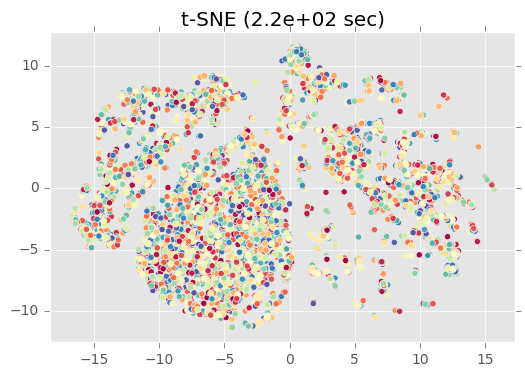

In [143]:
from matplotlib.ticker import NullFormatter

data = Data()
data.load_data(shfl=True)
n_points = data.X_train.shape[0]
# n_points = 10
# print(n_points)
n_components = 2
Xtemp, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
# fig = plt.figure(figsize=(15, 8))

t0 = time()
# X = data.X_train[:10,:]
X = data.X_train
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2f sec" % (t1 - t0))

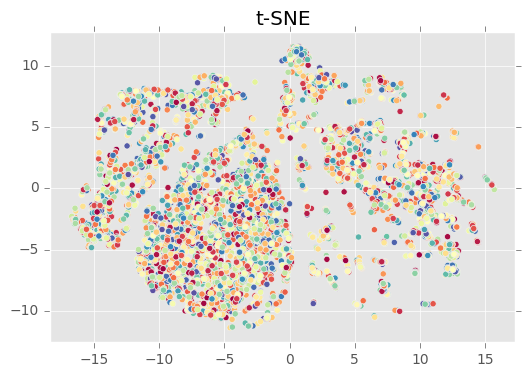

In [145]:
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
# plt.title("t-SNE (%.2f sec)" % (t1 - t0))
plt.title("t-SNE")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()